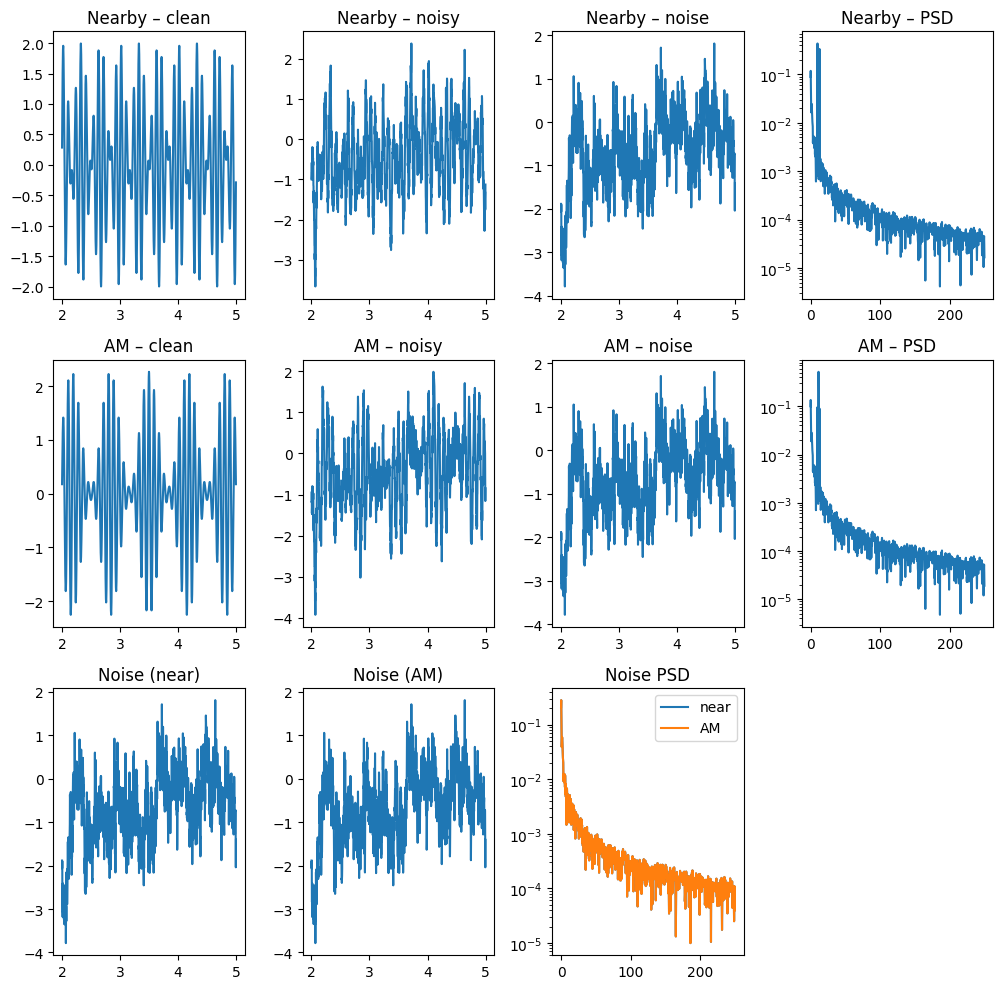

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Utilities
# -----------------------------
def colored_noise_1_f(n, fs, alpha=1.2, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    f = np.fft.rfftfreq(n, d=1/fs)
    amp = np.ones_like(f)
    amp[1:] = 1.0 / (f[1:] ** (alpha / 2))
    phase = rng.uniform(0, 2*np.pi, len(f))
    spec = amp * (np.cos(phase) + 1j*np.sin(phase))
    x = np.fft.irfft(spec, n=n)
    return (x - x.mean()) / x.std()

def welch_psd(x, fs, nperseg=2048, noverlap=1024):
    step = nperseg - noverlap
    win = np.hanning(nperseg)
    U = np.sum(win**2)
    P = 0
    count = 0
    for i in range(0, len(x)-nperseg, step):
        seg = x[i:i+nperseg] - np.mean(x[i:i+nperseg])
        X = np.fft.rfft(seg * win)
        P += (np.abs(X)**2) / (fs * U)
        count += 1
    return np.fft.rfftfreq(nperseg, 1/fs), P / count

# -----------------------------
# Generate signals
# -----------------------------
fs = 500
T = 12
t = np.arange(int(fs*T)) / fs
rng = np.random.default_rng(0)

# Nearby modes
x_near = np.sin(2*np.pi*10*t) + 0.9*np.sin(2*np.pi*13*t)

# AM dynamics (different mechanism, same peaks)
x_am = (1 + 0.9*np.sin(2*np.pi*1.5*t)) * np.sin(2*np.pi*11.5*t)

# Noise
noise = colored_noise_1_f(len(t), fs, rng=rng)

# Combine
x_near_noisy = x_near + 0.8*noise
x_am_noisy   = x_am   + 0.8*noise

# Noise only
noise_near = x_near_noisy - x_near
noise_am   = x_am_noisy   - x_am

# Normalize
def z(x): return (x - x.mean()) / x.std()
x_near, x_near_noisy = z(x_near), z(x_near_noisy)
x_am, x_am_noisy     = z(x_am), z(x_am_noisy)
noise_near, noise_am = z(noise_near), z(noise_am)

# PSDs
f, P_near = welch_psd(x_near_noisy, fs)
_, P_am   = welch_psd(x_am_noisy, fs)
_, P_n1   = welch_psd(noise_near, fs)
_, P_n2   = welch_psd(noise_am, fs)

# -----------------------------
# Plot
# -----------------------------
idx = (t > 2) & (t < 5)

fig, ax = plt.subplots(3, 4, figsize=(10, 10))

# Nearby modes
ax[0,0].plot(t[idx], x_near[idx]);        ax[0,0].set_title("Nearby – clean")
ax[0,1].plot(t[idx], x_near_noisy[idx]);  ax[0,1].set_title("Nearby – noisy")
ax[0,2].plot(t[idx], noise_near[idx]);    ax[0,2].set_title("Nearby – noise")
ax[0,3].plot(f, P_near); ax[0,3].set_yscale("log"); ax[0,3].set_title("Nearby – PSD")

# AM dynamics
ax[1,0].plot(t[idx], x_am[idx]);          ax[1,0].set_title("AM – clean")
ax[1,1].plot(t[idx], x_am_noisy[idx]);    ax[1,1].set_title("AM – noisy")
ax[1,2].plot(t[idx], noise_am[idx]);      ax[1,2].set_title("AM – noise")
ax[1,3].plot(f, P_am); ax[1,3].set_yscale("log"); ax[1,3].set_title("AM – PSD")

# Noise comparison
ax[2,0].plot(t[idx], noise_near[idx]); ax[2,0].set_title("Noise (near)")
ax[2,1].plot(t[idx], noise_am[idx]);   ax[2,1].set_title("Noise (AM)")
ax[2,2].plot(f, P_n1, label="near"); ax[2,2].plot(f, P_n2, label="AM")
ax[2,2].set_yscale("log"); ax[2,2].legend(); ax[2,2].set_title("Noise PSD")
ax[2,3].axis("off")

plt.tight_layout()
plt.show()


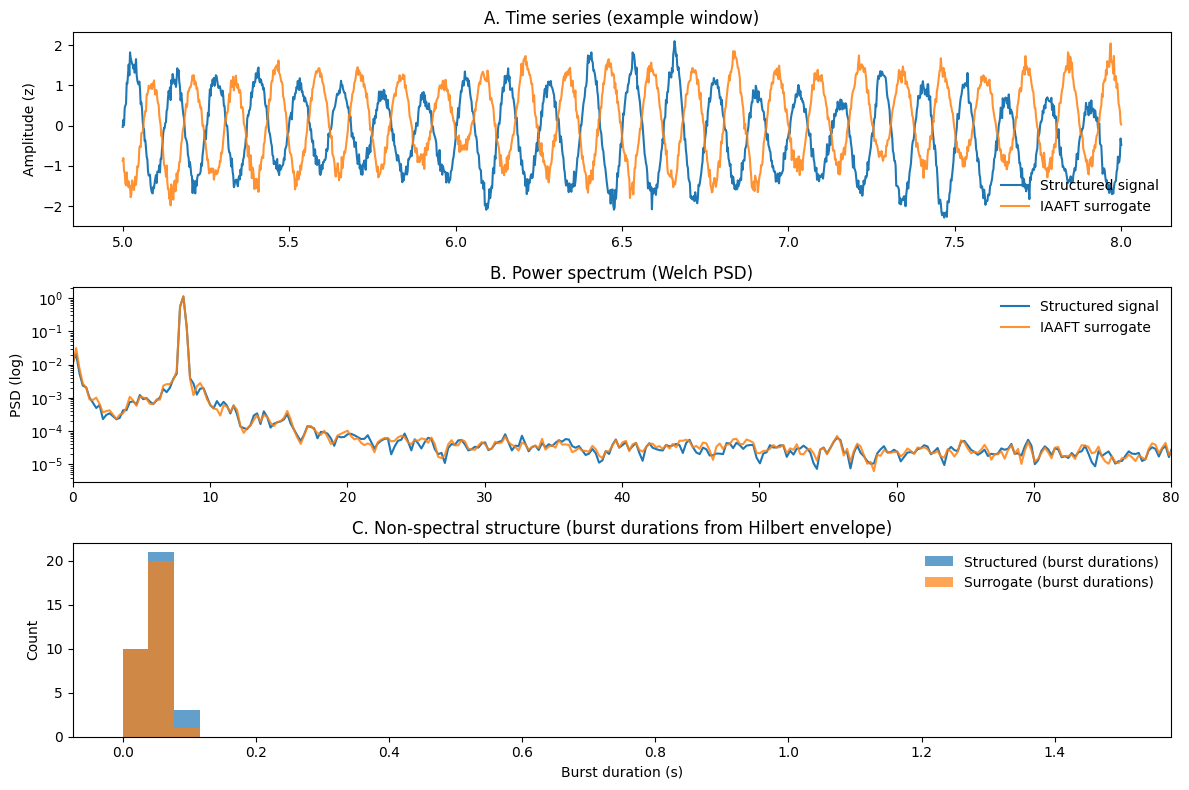

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Basic utilities (NumPy only)
# -----------------------------
def welch_psd(x, fs, nperseg=2048, noverlap=1024):
    x = np.asarray(x)
    step = nperseg - noverlap
    if step <= 0:
        raise ValueError("noverlap must be < nperseg")

    win = np.hanning(nperseg)
    U = np.sum(win**2)

    P = None
    count = 0
    for start in range(0, len(x) - nperseg + 1, step):
        seg = x[start:start+nperseg]
        seg = seg - np.mean(seg)
        X = np.fft.rfft(seg * win)
        Pseg = (np.abs(X)**2) / (fs * U)
        P = Pseg if P is None else (P + Pseg)
        count += 1

    f = np.fft.rfftfreq(nperseg, d=1/fs)
    return f, P / max(count, 1)

def analytic_signal(x):
    """
    Hilbert transform via FFT (NumPy only).
    Returns analytic signal z = x + i*H{x}.
    """
    x = np.asarray(x)
    n = x.size
    X = np.fft.fft(x)
    h = np.zeros(n)
    if n % 2 == 0:
        h[0] = 1
        h[n//2] = 1
        h[1:n//2] = 2
    else:
        h[0] = 1
        h[1:(n+1)//2] = 2
    z = np.fft.ifft(X * h)
    return z

def iaaft_surrogate(x, n_iter=200, rng=None):
    x = np.asarray(x).astype(float)
    n = x.size
    rng = np.random.default_rng() if rng is None else rng
    x_sorted = np.sort(x)
    target_mag = np.abs(np.fft.rfft(x))
    y = rng.permutation(x)
    for _ in range(n_iter):
        Y = np.fft.rfft(y)
        Y = target_mag * np.exp(1j * np.angle(Y))
        y = np.fft.irfft(Y, n=n)
        ranks = np.argsort(np.argsort(y))
        y = x_sorted[ranks]
    return y

def zscore(x):
    x = np.asarray(x)
    return (x - x.mean()) / (x.std() + 1e-12)

def burst_durations(envelope, fs, thresh_quantile=0.85, min_ms=30):
    """
    Compute burst durations where envelope exceeds a threshold.
    Threshold is set by envelope quantile.
    """
    thr = np.quantile(envelope, thresh_quantile)
    above = envelope > thr

    # find contiguous True segments
    durations = []
    i = 0
    n = len(above)
    min_len = int((min_ms/1000) * fs)
    while i < n:
        if above[i]:
            j = i
            while j < n and above[j]:
                j += 1
            if (j - i) >= min_len:
                durations.append((j - i) / fs)
            i = j
        else:
            i += 1
    return np.array(durations), thr

# -----------------------------
# Generate a structured LFP-like signal
# -----------------------------
fs = 500
T = 20.0
t = np.arange(int(T*fs)) / fs
rng = np.random.default_rng(0)

# Theta carrier
f_theta = 8.0
theta = np.sin(2*np.pi*f_theta*t)

# Bursty envelope: sparse events convolved with an exponential kernel
p_event = 0.015  # event probability per sample
events = (rng.random(len(t)) < p_event).astype(float)
tau = 0.15  # seconds
kernel_len = int(3*tau*fs)
k = np.exp(-np.arange(kernel_len)/(tau*fs))
env = np.convolve(events, k, mode="same")
env = env / (env.max() + 1e-12)

# Structured signal: theta with bursty amplitude + mild 1/f-ish background
# (simple colored noise: integrate white noise once -> ~1/f^2-ish, then mix)
white = rng.standard_normal(len(t))
brown = np.cumsum(white)
brown = zscore(brown)
x = (0.9 + 1.6*env) * theta + 0.25*brown + 0.10*rng.standard_normal(len(t))
x = zscore(x)

# -----------------------------
# Build IAAFT surrogate
# -----------------------------
y = iaaft_surrogate(x, n_iter=300, rng=rng)
y = zscore(y)

# -----------------------------
# Compute PSDs
# -----------------------------
f, Px = welch_psd(x, fs)
_, Py = welch_psd(y, fs)

# -----------------------------
# Envelope + burst stats
# -----------------------------
env_x = np.abs(analytic_signal(x))
env_y = np.abs(analytic_signal(y))

bursts_x, thr_x = burst_durations(env_x, fs, thresh_quantile=0.85, min_ms=30)
bursts_y, thr_y = burst_durations(env_y, fs, thresh_quantile=0.85, min_ms=30)

# -----------------------------
# Plot (publication-ready 3-panel)
# -----------------------------
# show a short window of time series
t0, t1 = 5.0, 8.0
idx = (t >= t0) & (t <= t1)

plt.figure(figsize=(12, 8))

# (A) Time series
ax1 = plt.subplot(3, 1, 1)
ax1.plot(t[idx], x[idx], label="Structured signal")
ax1.plot(t[idx], y[idx], label="IAAFT surrogate", alpha=0.85)
ax1.set_ylabel("Amplitude (z)")
ax1.set_title("A. Time series (example window)")
ax1.legend(frameon=False)

# (B) PSD overlay
ax2 = plt.subplot(3, 1, 2)
ax2.plot(f, Px, label="Structured signal")
ax2.plot(f, Py, label="IAAFT surrogate", alpha=0.85)
ax2.set_yscale("log")
ax2.set_xlim(0, 80)
ax2.set_ylabel("PSD (log)")
ax2.set_title("B. Power spectrum (Welch PSD)")
ax2.legend(frameon=False)

# (C) Envelope / burst statistic
ax3 = plt.subplot(3, 1, 3)
# plot burst duration distributions as simple hist overlays
bins = np.linspace(0, 1.5, 40)
ax3.hist(bursts_x, bins=bins, alpha=0.7, label="Structured (burst durations)")
ax3.hist(bursts_y, bins=bins, alpha=0.7, label="Surrogate (burst durations)")
ax3.set_xlabel("Burst duration (s)")
ax3.set_ylabel("Count")
ax3.set_title("C. Non-spectral structure (burst durations from Hilbert envelope)")
ax3.legend(frameon=False)

plt.tight_layout()
plt.show()


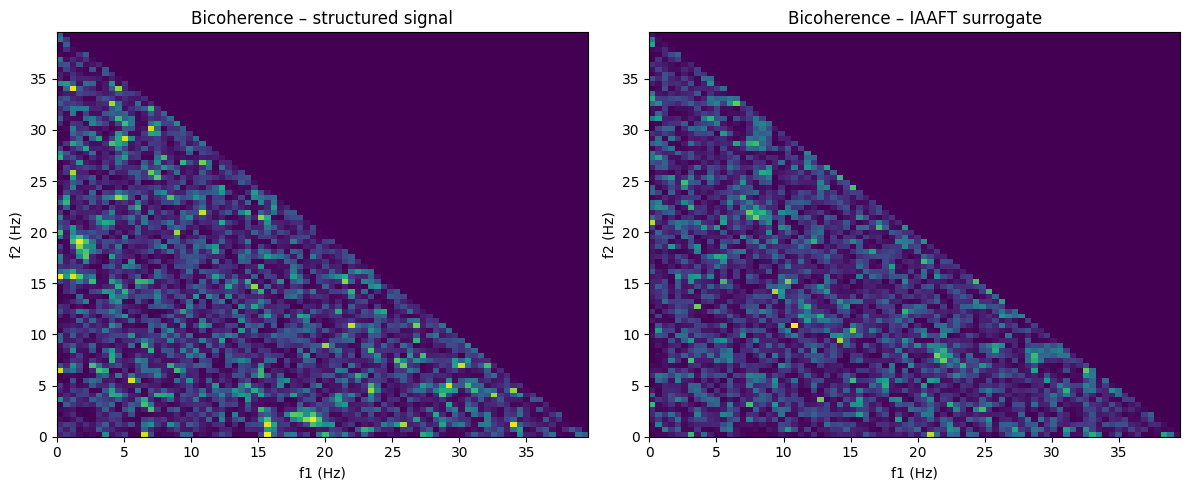

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def bicoherence_map(x, fs, nperseg=2048, noverlap=1024, fmax=60):
    """
    Minimal bicoherence estimate (NumPy-only).
    Returns (f, B) where B is bicoherence matrix over f<=fmax.
    """
    x = np.asarray(x)
    step = nperseg - noverlap
    win = np.hanning(nperseg)
    starts = range(0, len(x) - nperseg + 1, step)

    f = np.fft.rfftfreq(nperseg, d=1/fs)
    keep = f <= fmax
    f = f[keep]
    nF = len(f)

    # accumulators
    num = np.zeros((nF, nF), dtype=np.complex128)
    den1 = np.zeros((nF, nF), dtype=float)
    den2 = np.zeros((nF, nF), dtype=float)

    for s in starts:
        seg = x[s:s+nperseg] - np.mean(x[s:s+nperseg])
        X = np.fft.rfft(seg * win)[keep]

        # Outer products for bispectrum
        for i in range(nF):
            for j in range(nF):
                k = i + j
                if k < nF:
                    num[i, j] += X[i] * X[j] * np.conj(X[k])
                    den1[i, j] += np.abs(X[i] * X[j])**2
                    den2[i, j] += np.abs(X[k])**2

    B = np.abs(num)**2 / (den1 * den2 + 1e-18)
    return f, B

# Compute bicoherence for x and y (can take some seconds depending on sizes)
fB, Bx = bicoherence_map(x, fs, nperseg=1024, noverlap=512, fmax=40)
_,  By = bicoherence_map(y, fs, nperseg=1024, noverlap=512, fmax=40)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(Bx.T, origin="lower", aspect="auto",
           extent=[fB[0], fB[-1], fB[0], fB[-1]])
plt.title("Bicoherence – structured signal")
plt.xlabel("f1 (Hz)")
plt.ylabel("f2 (Hz)")

plt.subplot(1, 2, 2)
plt.imshow(By.T, origin="lower", aspect="auto",
           extent=[fB[0], fB[-1], fB[0], fB[-1]])
plt.title("Bicoherence – IAAFT surrogate")
plt.xlabel("f1 (Hz)")
plt.ylabel("f2 (Hz)")

plt.tight_layout()
plt.show()
